# Data Engineering Notebook

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load Dataset

In [5]:
df = pd.read_excel("raw_data.xlsx", sheet_name="species_heights")
df = df[["intertidal_sitename","Mean(z_rock_height)","species_lump"]] # drop useless cols

## EDA on sites


#### Check the species categories for each site (need to make sure all these sites have same species distributions)
- we only take those species "Yes" for all sites
- Generate two cols:
-   cat_01: classification on focus species / Other Species
-   cat_02: classification between focus species

In [6]:
# check the species breakdown for each site
eda_df = df.copy()
spec_list = eda_df["species_lump"].unique().tolist()
site_list = eda_df["intertidal_sitename"].unique().tolist()
eda_df_01 = pd.DataFrame()
eda_df_01["species"] = spec_list
for site in site_list:
    check_list = []
    for spec in spec_list:
        if spec in eda_df.loc[eda_df["intertidal_sitename"]==site]["species_lump"].tolist():
            check_list.append("Yes")
        else:
            check_list.append(None)
    eda_df_01[site] = check_list
eda_df_01.dropna(inplace=True)
species_list = eda_df_01["species"].to_list()
# generate species_list except for "Other Species"
species_list.remove("Other Species")
# Create two categories for modeling
df["species_cat_01"] = df["species_lump"].apply(lambda x: "Other Species" if x not in species_list else "Focus Species")
df["species_cat_02"] = df["species_lump"].apply(lambda x: "Other Species" if x not in species_list else x)
df

,intertidal_sitename,Mean(z_rock_height),species_lump,species_cat_01,species_cat_02
0,Bob Creek,4.052500,Balanus glandula,Focus Species,Balanus glandula
1,Bob Creek,4.044423,Balanus glandula,Focus Species,Balanus glandula
2,Bob Creek,4.036170,Other Species,Other Species,Other Species
3,Bob Creek,4.027484,Other Species,Other Species,Other Species
4,Bob Creek,4.018874,Other Species,Other Species,Other Species
...,...,...,...,...,...
53666,White Point,1.909853,Mytilus californianus,Focus Species,Mytilus californianus
53667,White Point,1.944892,Other Species,Other Species,Other Species
53668,White Point,1.980000,Other Species,Other Species,Other Species
53669,White Point,2.049914,Balanus glandula,Focus Species,Balanus glandula


### Visualizations of Mean(z-rock_height)

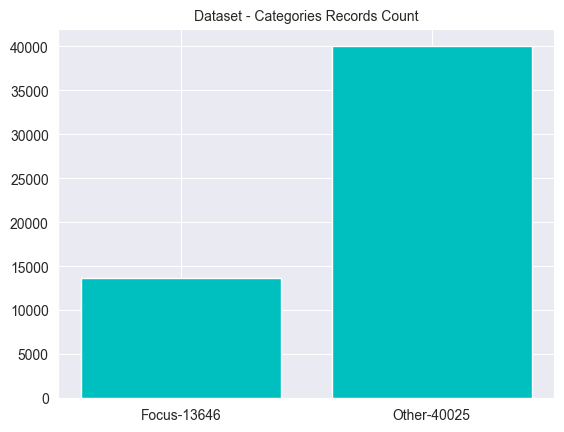

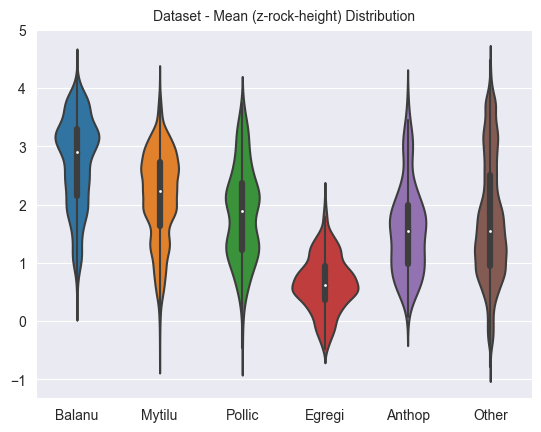

In [4]:
grouped_data = df.groupby(by="species_cat_01").count().sort_values(by="Mean(z_rock_height)")
x_label = ["Focus", "Other"]
y_value = grouped_data["Mean(z_rock_height)"].to_list()
x_label_with_no = []
for idx in range(len(x_label)):
    x_label_with_no.append(x_label[idx] + "-" + str(y_value[idx]))
plt.bar(x_label_with_no, y_value, color="c")
plt.title("Dataset - Categories Records Count", fontsize = 10)
plt.show()


# define the abrrev
spcies_label = [i[0:6] for i in species_list]

overall_list = []
for spec in species_list + ["Other Species"]:
    overall_list.append(df.loc[df["species_cat_02"]==spec]["Mean(z_rock_height)"].to_list())
sns.violinplot(data = overall_list)
plt.xticks(ticks=[i for i in range(len(species_list + ["Other Species"]))],labels = spcies_label + ["Other"],)
plt.title("Dataset - Mean (z-rock-height) Distribution", fontsize = 10)
plt.show()

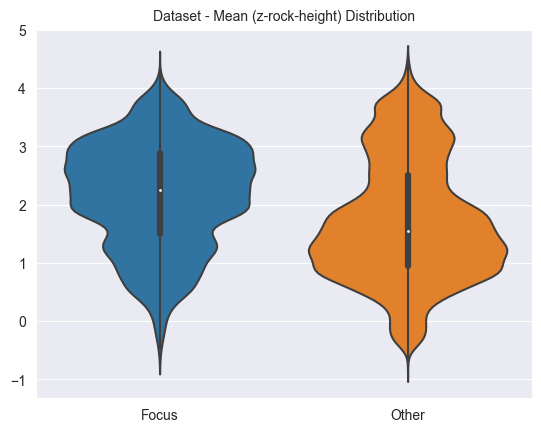

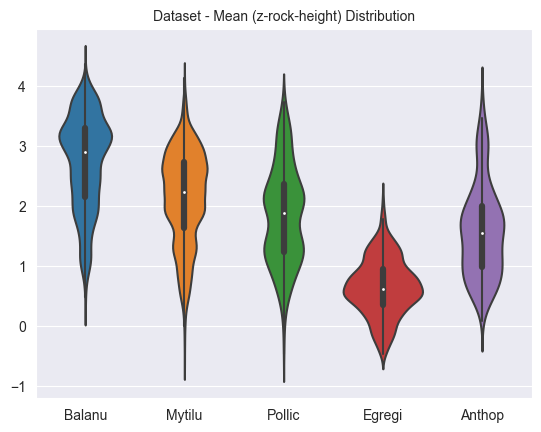

In [5]:
overall_list = []
for spec in ["Focus Species", "Other Species"]:
    overall_list.append(df.loc[df["species_cat_01"]==spec]["Mean(z_rock_height)"].to_list())
sns.violinplot(data = overall_list)
plt.xticks(ticks=[i for i in range(len(["Focus Species", "Other Species"]))],labels = ["Focus", "Other"])
plt.title("Dataset - Mean (z-rock-height) Distribution", fontsize = 10)
plt.show()

overall_list = []
for spec in species_list:
    overall_list.append(df.loc[df["species_cat_02"]==spec]["Mean(z_rock_height)"].to_list())
sns.violinplot(data = overall_list)
plt.xticks(ticks=[i for i in range(len(species_list))],labels = spcies_label)
plt.title("Dataset - Mean (z-rock-height) Distribution", fontsize = 10)
plt.show()

## Phase I - Classification between Focus Species & Other Species

#### A. Prepare Test Dataset

In [5]:
df_phase1 = df.copy()
grouped_data = df_phase1.groupby(by="species_cat_01").count().sort_values(by="Mean(z_rock_height)")
x_label = grouped_data.index.to_list()
y_value = grouped_data["Mean(z_rock_height)"].to_list()

In [6]:
test_size = int(min(y_value) * 0.2)
trainset = pd.DataFrame()
testset = pd.DataFrame()
for spec in df_phase1["species_cat_01"].unique().tolist():
    temp_df = df_phase1.loc[df_phase1["species_cat_01"] == spec].sample(frac = 1) # shuffle subset
    trainset = pd.concat([trainset,temp_df.tail(len(temp_df)-test_size)]) # concatenate trainset
    testset = pd.concat([testset,temp_df.head(test_size)]) # concatenate testset
testset = testset[["Mean(z_rock_height)","species_cat_01"]]
print(testset.groupby(by="species_cat_01").count())

                Mean(z_rock_height)
species_cat_01                     
Focus Species                  2729
Other Species                  2729


#### B. Resampling to balance the trainset

In [7]:
# set weights for those speices to balance the sampling
weight_dict = {}
for idx in range(len(x_label)):
    # set 1000 as base
    weight_dict[x_label[idx]] = 1 / y_value[idx]
trainset["weight"] = trainset["species_cat_01"].apply(lambda x: weight_dict[x])
trainset = trainset.sample(frac=1, replace=True, weights="weight")
trainset = trainset[["Mean(z_rock_height)","species_cat_01"]]
print(trainset.groupby(by="species_cat_01").count())

                Mean(z_rock_height)
species_cat_01                     
Focus Species                 22168
Other Species                 26045


#### C. Save to local disk

In [8]:
trainset.to_csv("phase_1_trainset.csv", index = None)
testset.to_csv("phase_1_testset.csv", index = None)

## Phase II - Classification in Focus Species

#### A. Prepare Test Dataset

In [9]:
df_phase2 = df.copy()
df_phase2 = df_phase2.loc[df_phase2["species_cat_02"] != "Other Species"]
grouped_data = df_phase1.groupby(by="species_cat_02").count().sort_values(by="Mean(z_rock_height)")
x_label = grouped_data.index.to_list()
y_value = grouped_data["Mean(z_rock_height)"].to_list()

In [10]:
test_size = int(min(y_value) * 0.2)
trainset = pd.DataFrame()
testset = pd.DataFrame()
for spec in df_phase2["species_cat_02"].unique().tolist():
    temp_df = df_phase2.loc[df_phase2["species_cat_02"] == spec].sample(frac = 1) # shuffle subset
    trainset = pd.concat([trainset,temp_df.tail(len(temp_df)-test_size)]) # concatenate trainset
    testset = pd.concat([testset,temp_df.head(test_size)]) # concatenate testset
testset = testset[["Mean(z_rock_height)","species_cat_02"]]
print(testset.groupby(by="species_cat_02").count())

                           Mean(z_rock_height)
species_cat_02                                
Anthopleura elegantissima                   58
Balanus glandula                            58
Egregia menziesii                           58
Mytilus californianus                       58
Pollicipes polymerus                        58


#### B. Resampling to balance the trainset

In [11]:
# set weights for those speices to balance the sampling
weight_dict = {}
for idx in range(len(x_label)):
    # set 1000 as base
    weight_dict[x_label[idx]] = 1 / y_value[idx]
trainset["weight"] = trainset["species_cat_02"].apply(lambda x: weight_dict[x])
trainset = trainset.sample(frac=1, replace=True, weights="weight")
trainset = trainset[["Mean(z_rock_height)","species_cat_02"]]
print(trainset.groupby(by="species_cat_02").count())

                           Mean(z_rock_height)
species_cat_02                                
Anthopleura elegantissima                 2288
Balanus glandula                          2853
Egregia menziesii                         2746
Mytilus californianus                     2874
Pollicipes polymerus                      2595


#### C. Save to local disk

In [12]:
trainset.to_csv("phase_2_trainset.csv", index = None)
testset.to_csv("phase_2_testset.csv", index = None)